# Nepali Handwritten Character Recognition Using CNN
---

This notebook demonstrates the implementation of convolutional neural networks for training deep learning models that is capable of identifying handwritten Nepali characters.

- Author: Dipesh Jung Pandey

# Table of Contents

1. Overview
2. Data Preparation
3. Baseline Model
4. Extended Model
6. Prediction
7. Conclusion
---

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## 1. Overview

#### Convolutional Neural Networks

Convolutional neural networks are deep learning algorithms that are most commonly used for training machines to recognize and predict objects from input images. An example of a convolutional neural network is shown in the figure below.<br><br>


![convnet](images/convnet.png)

<br><br>
In this notebook, we will implement multiple variations of convolutional neural networks to recognize and predict Nepali handwritten characters from an input image. Each model will be initialized with a different set of parameters but will remain consistent on the pattern of layers that are used. Each model will be evaluated and compared at the end of the notebook.  

<br>

#### Dataset

- The dataset used here is the DHCD dataset which contains 92,000 images and its corresponding labels of Nepali handwritten characters. 
- The dataset is stored in `.npz` file format and consumes a total storage of 90.5 MB. 
- The dataset is accessible in the link provided <a href="https://github.com/Prasanna1991/DHCD_Dataset">here</a>.
- The images in the dataset have already been divided into training and test sets with 85% training examples and 15% test examples. 
- Each image is a grayscale image with pixel values ranging from 0-255. 
- Each image is also pre-processed with a padding of 2 pixels on all sides. Since the total size of each image is 32x32 pixels, each character is actually contained within a 28x28 pixel dimension. 

Details of the dataset are summarized in the table shown below. 

<br>


| Data                  |# Examples   |  Shape             |
|-----------------------|-------------|--------------------|
| Training set images   | 78200   	  | (78200, 32, 32)    |
| Training set labels   | 78200       | (78200, )          |
| Test set images       | 13800       | (13800, 32, 32)    |
| Test set labels       |  13800      | (13800, )          |

<br>

---

## 2. Data Preparation 

In [2]:
# Load dataset
data_npz = np.load("dataset/dataset.npz")

# Training examples
img_train = data_npz['arr_0']
lbl_train = data_npz['arr_1']

# Test examples
img_test = data_npz['arr_2']
lbl_test = data_npz['arr_3']

print("Number of training examples: {}".format(len(img_train)))
print("Number of test examples: {}".format(len(img_test)))

Number of training examples: 78200
Number of test examples: 13800


The dataset is initially arranged in an ascending sequence of characters and digits. This may have an undesired affect on the learning process of the neural network. To avoid this from happening, the dataset is shuffled while retaining the index of each image and its corresponding label.

In [3]:
# Define function to shuffle data
def shuffle_dataset(img_train, lbl_train, img_test, lbl_test):
    image_train, label_train = shuffle(img_train, lbl_train)
    image_test, label_test = shuffle(img_test, lbl_test)
    return (image_train, label_train), (image_test, label_test)

In [4]:
(image_train, label_train), (image_test, label_test) = shuffle_dataset(img_train, lbl_train, img_test, lbl_test)

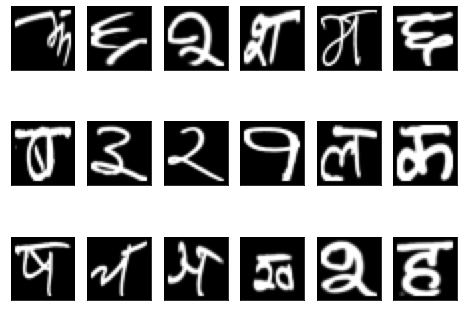

In [5]:
# Plot a few examples
fig = plt.figure(figsize=(8,6))
rows = 3
columns = 6
for i in range(1, rows*columns+1):
    img = image_train[23+i]
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
# Examine a single image instance
print("Image matrix:\n\n{}\n".format(image_train[28]))
print("Dimension: {}".format(image_train[28].shape))
print("Minimum pixel value: {}".format(np.min(image_train[28])))
print("Maximum pixel value: {}".format(np.max(image_train[28])))

Image matrix:

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 239   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Dimension: (32, 32)
Minimum pixel value: 0
Maximum pixel value: 255


To implement the neural network using the Keras framework, the shape of the images must be changed to contain the number of channels on each image. In our case of grayscale images, this number will be equal to 1 for all examples.

We will also normalize the pixel values of images from 0-255 to a range of 0-1 for more efficient computation when training the neural network.

In [7]:
# reshape to [samples][width][height][channels]
image_train = image_train.reshape(-1, 32, 32, 1).astype('float32')
image_test = image_test.reshape(-1, 32, 32, 1).astype('float32')

#normalize inputs to 0-1 from 0-255
image_train = image_train/255
image_test = image_test/255

print("Shape of training set: {}".format(image_train.shape))
print("Shape of test set: {}".format(image_test.shape))
print("Minimum pixel value: {}".format(np.min(image_train[28])))
print("Maximum pixel value: {}".format(np.max(image_train[28])))

Shape of training set: (78200, 32, 32, 1)
Shape of test set: (13800, 32, 32, 1)
Minimum pixel value: 0.0
Maximum pixel value: 1.0


Each image label in the dataset is assigned an integer value which represents a class in the set of possible character classses in the Nepali language. This process known as integer encoding and is demonstrated below:

In [8]:
print(label_train)

[13  3 15 ... 10  3 25]


However, for categorical datasets, integer encoding is not sufficient. Integer encoding assumes ordinal relationship between classes which can have undesirable consequences while classifying character images. To prevent this from happening, we will use a binarization technique known as one-hot encoding. This method will convert the integers into a set a binary values where the position of the true value indicates the category of the classified image.

Since the integers encoded in the labels range from 1-46, we will have to convert it into the range of 0-45 for proper one-hot encoding of the labels.

In [9]:
# convert to range 0-45
label_train = label_train -1
label_test = label_test - 1
# one-hot encode output classes
label_train = keras.utils.to_categorical(label_train, num_classes=46, dtype='float32')
label_test = keras.utils.to_categorical(label_test, num_classes=46, dtype='float32')

print(label_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


---

## 3. Baseline Model


In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD

We will first develop a simple baseline model to demonstrate the fundamental steps in building a simple convolutional neural network. Afterwards, we will explore more complex models and make comparisions to the baseline model.

Model description:

- The baseline model contains 1 convolution layer, 1 max pooling layer, 1 flattening layer and 2 fully connected layers. 
- The convolution layer contains 32 units with a kernel size of 5 each. 
- A ReLU activation function is applied on the ouput of the convolution operation. 
- The max pooling layer follows the convolution layer using a pool size of 2 pixels. 
- The reduced output from the pooling layer is then flattened into a one dimensional vector input. 
- A fully connected layer is able to process the vector and apply another ReLU activation function. 
- A final fully connected layer applies the multi-class logistic function called softmax function to generate the final output vector.
- The first fully connected layer contains 400 units and the final fully connected layer included units equivalent to the number of classes in the classification problem 46.
- The model uses a gradient descent technique known as stochastic gradient descent (SGD). A learning rate of 0.01 and a momentum of 0.9 is applied on the gradient descent. 
- The loss is evaluated using cross entropy for categorical data. 
- The model is specified to provide data for the accuracy when training the model.

<br>

In [11]:
def baselineModel():
    # define model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=(32,32,1)))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(46, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Initialize model and display summary
baseline_model = baselineModel()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               2509200   
_________________________________________________________________
dense_1 (Dense)              (None, 46)                18446     
Total params: 2,528,478
Trainable params: 2,528,478
Non-trainable params: 0
_________________________________________________________________


We will run the model for 20 epochs with a batch size of 128 inputs per batch. The data will be shuffled on each epoch which helps reduce biased estimation of the true gradient.

In [13]:
history = baseline_model.fit(
                image_train, 
                label_train, 
                validation_data=(image_test, label_test), 
                epochs=20, 
                batch_size=128,
                shuffle=True,
                verbose=1)

Epoch 1/20
611/611 [==============================] - 7s 6ms/step - loss: 3.0468 - accuracy: 0.2754 - val_loss: 1.1940 - val_accuracy: 0.6801
Epoch 2/20
611/611 [==============================] - 3s 6ms/step - loss: 1.1453 - accuracy: 0.6942 - val_loss: 0.9370 - val_accuracy: 0.7463
Epoch 3/20
611/611 [==============================] - 3s 6ms/step - loss: 0.8984 - accuracy: 0.7597 - val_loss: 0.7410 - val_accuracy: 0.7990
Epoch 4/20
611/611 [==============================] - 3s 6ms/step - loss: 0.7075 - accuracy: 0.8111 - val_loss: 0.6152 - val_accuracy: 0.8350
Epoch 5/20
611/611 [==============================] - 3s 6ms/step - loss: 0.5760 - accuracy: 0.8447 - val_loss: 0.5192 - val_accuracy: 0.8580
Epoch 6/20
611/611 [==============================] - 3s 6ms/step - loss: 0.4832 - accuracy: 0.8700 - val_loss: 0.4717 - val_accuracy: 0.8711
Epoch 7/20
611/611 [==============================] - 3s 5ms/step - loss: 0.4219 - accuracy: 0.8851 - val_loss: 0.3997 - val_accuracy: 0.8915
Epoch 

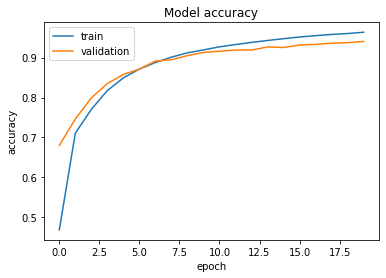

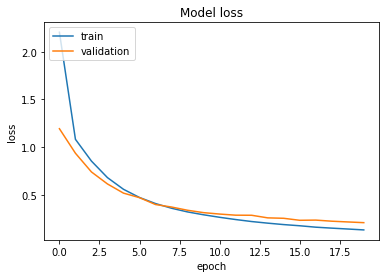

In [14]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
baseline_model.evaluate(image_test, label_test, verbose=0, batch_size=128)

[0.20898884534835815, 0.9409420490264893]

#### Observation

The graph plotted above demonstrates the progress of training and validating the neural network on each iteration with respect to accuracy and loss. Following the 8<sup>th</sup> epoch, we can observe a relative improvement in accuracy and loss of training examples compared to validation examples. Nonetheless, we find a gradual increase in validation accuracy and a gradual decrease in validation loss which indicates that the model is still improving with each iteration of gradient descent. The baseline model has resulted in a test accuracy of around `94%` and test loss of approximately `0.21`, which is astonishingly exceptional given the simplicity of the model used here. This may be attributed by factors such as the amount and quality of data available, effectiveness of the convolutional neural network architecture and selection of gradient descent and loss functions.

---

## 4. Extended Model

We will now attempt to improve upon the baseline model used previously by building a more accurate model. We will utilize more convolution layers for improving the model's feature detection capability. We will build a deeper neural network by adding more layers and learning units to our model. To prevent overfitting the model, we will make use of two regularization techniques- dropout and data augmentation.

We begin by initializing and preparing a new instance of the dataset.

In [16]:
# initialize training and test data
(image_train, label_train), (image_test, label_test) = shuffle_dataset(img_train, lbl_train, img_test, lbl_test)

# reshape to [samples][width][height][channels]
image_train = image_train.reshape(-1, 32, 32, 1).astype('float32')
image_test = image_test.reshape(-1, 32, 32, 1).astype('float32')

# normalize inputs to 0-1 from 0-255
image_train = image_train/255
image_test = image_test/255

# convert to range 0-45
label_train = label_train -1
label_test = label_test - 1

# one-hot encode output classes
label_train = keras.utils.to_categorical(label_train)
label_test = keras.utils.to_categorical(label_test)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Upon exprimenting with various data augmentation techniques, the following three augmentations were selected for implementing while training the model. These augmentations include:

- Shear
- Zoom
- Shift

The parameters for these augmentation methods were selected carefully by applying and observing various transformations with consideration towards the possible impact on traning the model. Examples of these augmentations are shown below.

Shear: 


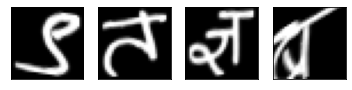

In [18]:
# Shear
print("Shear: ")

# Generate shear
train_datagen = ImageDataGenerator(
    shear_range=40)

# Plot
fig = plt.figure(figsize=(6,2))
i = 1
rows = 1
columns = 4
for batch in train_datagen.flow(image_train, batch_size=1):
    aug_img = batch[0].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(aug_img, cmap=plt.get_cmap('gray'))  
    if i > 3:
        break
    i+=1

Zoom: 


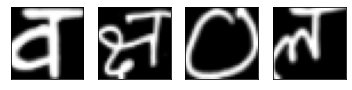

In [19]:
# Zoom
print("Zoom: ")

# Generate zoom
train_datagen = ImageDataGenerator(
    zoom_range=[0.8,0.9])

# Plot
fig = plt.figure(figsize=(6,2))
i = 1
rows = 1
columns = 4
for batch in train_datagen.flow(image_train, batch_size=1):
    aug_img = batch[0].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(aug_img, cmap=plt.get_cmap('gray'))  
    if i > 3:
        break
    i+=1

Shifts: 


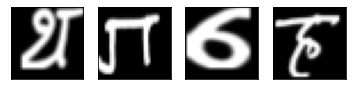

In [20]:
# Horizantal and Vertical Shift
print("Shifts: ")

# Generate shifts
train_datagen = ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1)

# Plot
fig = plt.figure(figsize=(6,2))
i = 1
rows = 1
columns = 4
for batch in train_datagen.flow(image_train, batch_size=1):
    aug_img = batch[0].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(aug_img, cmap=plt.get_cmap('gray'))  
    if i > 3:
        break
    i+=1

The combined augmentations are configred to create the final ImageDataGenerator. The fit method is called to make calculations for transformation of the data.

In [21]:
# Final augmented data generation
train_datagen = ImageDataGenerator(
    shear_range=40,
    zoom_range=[0.8,0.9],
    height_shift_range=0.1,
    width_shift_range=0.1)

# Fit the augmentation to training data
#train_datagen.fit(image_train)

In [22]:
from tensorflow.keras.layers import Dropout

The model has the following properties.

- The model contains 4 convolution layers, 2 max pooling layers, 2 dropout layers and three fully connected layers. 
- The first two convolution layers contain 32 kernels of size 3 each. The small kernel size allows the model to detect small features such as edges early on neural network. The layers implement the same padding technique to maintain the size of the input. This allows extending the model into deeper layers.
- The remaining two convolution layers have 64 kernels each with a size of 5. This allow sdetecting lerger more abstract features from the images.
- All convolution layers apply the relu activation function
- Two max pooling layers are applied after each consecutive convolution layers. Both pooling matrices have a size of 2.
- Two dropout layers are implemented after each max pooling layer. A dropout rate of 0.8 is applied on both cases. This means 20% of the nodes are disabled in locations where the dropout layer is applied.
- After flattening the inputs, 2 fully connected layers are applied with the relu activation function. The third fully connected layer applies the softmax function to generate the final predictions of the neural network.
- The compilation of the model is similar to that of the baseline model. It uses a stochastic gradient descent with learning rate of 0.001 and momentum of 0.9.
- The cross entropy loss function is used to calculate the cost of the model.

In [23]:
def extendedModel():
    # define model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(32,32,1), padding='same'))
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=5, activation='relu'))
    model.add(Conv2D(64, kernel_size=5, activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(46, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# Initialize model and display summary
extended_model = extendedModel()
extended_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)         

In [26]:
xtd_history = extended_model.fit(
                image_train, 
                label_train,
                validation_data=(image_test, label_test),
                epochs=20,
                batch_size=128,
                shuffle=True,
                verbose=1)

# Training with data augmentation
# xtd_history = extended_model.fit(
#                 train_datagen.flow(image_train, label_train, batch_size=128)
#                 validation_data=(image_test, label_test),
#                 epochs=20,
#                 shuffle=True,
#                 verbose=1)

Epoch 1/20
611/611 [==============================] - 9s 14ms/step - loss: 3.8241 - accuracy: 0.0238 - val_loss: 3.6474 - val_accuracy: 0.1302
Epoch 2/20
611/611 [==============================] - 8s 13ms/step - loss: 2.8474 - accuracy: 0.2628 - val_loss: 0.9856 - val_accuracy: 0.7199
Epoch 3/20
611/611 [==============================] - 8s 13ms/step - loss: 1.0252 - accuracy: 0.7006 - val_loss: 0.5195 - val_accuracy: 0.8476
Epoch 4/20
611/611 [==============================] - 8s 14ms/step - loss: 0.6534 - accuracy: 0.8048 - val_loss: 0.3699 - val_accuracy: 0.8931
Epoch 5/20
611/611 [==============================] - 8s 14ms/step - loss: 0.4817 - accuracy: 0.8551 - val_loss: 0.3119 - val_accuracy: 0.9075
Epoch 6/20
611/611 [==============================] - 8s 13ms/step - loss: 0.3965 - accuracy: 0.8795 - val_loss: 0.2554 - val_accuracy: 0.9246
Epoch 7/20
611/611 [==============================] - 8s 14ms/step - loss: 0.3381 - accuracy: 0.8961 - val_loss: 0.2239 - val_accuracy: 0.9343

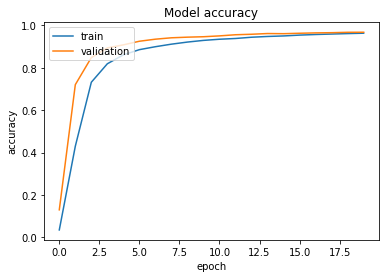

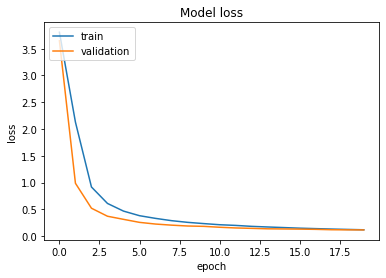

In [27]:
# Accuracy
plt.plot(xtd_history.history['accuracy'])
plt.plot(xtd_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(xtd_history.history['loss'])
plt.plot(xtd_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
extended_model.evaluate(image_test, label_test, verbose=0, batch_size=128)

[0.11435025930404663, 0.9669564962387085]

#### Observation

The extended model has improved the accuracy of the model from `94%` to `97%` and reduced the loss from `0.21` to `0.10` compared to the baseline model. Based on research and findings of other machine learning implementations, this improvement can be attributed to the deeper neural network architecture allowing more complex learning to be accomplished. It is also worth noting that despite using less number of parameters (baseline: 2,528,478 and current: 618,042), the extended model was capable of obtaining a better result. This observation complements the effectiveness and efficiency of deep neural architectures. The graphs plotted above demonstrate the convergance of training and validation loss and accuracy of the model. This indicates that the model is fully trained without any overfitting towards training examples.

The implementation of the extended model avoided the use of data augmentation due to undesired effects on the result. After running the model a few times with different configurations, it was established that the model performed better without the use of data augmentation. Use of data augmentation resulted in models that had large amounts of loss in validation data and reduced validation accuracy. Due to possible low variance in data contained in training examples and test examples, data augmentation was recognized as an unnecessary process for this particular implementation of convolutional neural network. Nonetheless, data augmentation still plays an important role in training models that are capable of predicting images in relatively more abstract forms.

---

In [29]:
import cv2
from utils import decode_predictions
from tensorflow.keras.models import load_model

## 5. Prediction


In this section, we will use the model trained earlier to predict a character contained in an image that has been obtained from an external source. The image has been pre-processed and prepared for passing in the model.

<br>

In [30]:
model = load_model('model.h5')

(32, 32)


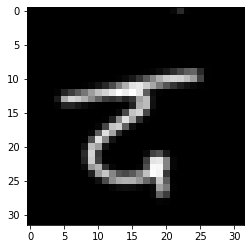

In [31]:
sample = cv2.imread('images/sample2.png', cv2.IMREAD_GRAYSCALE)
print(sample.shape)
plt.imshow(sample, cmap=plt.get_cmap('gray'))
plt.show()

In [32]:
image_sample = sample.reshape(-1,32,32,1).astype('float32')
image_sample = image_sample/255
preds = model.predict(image_sample)
print(len(preds[0]))
preds

46


array([[1.03390390e-04, 3.50260641e-04, 1.71351014e-04, 5.94021229e-04,
        2.88695004e-03, 1.02877654e-02, 2.21997127e-02, 5.05446747e-04,
        3.13840337e-06, 7.00555451e-04, 1.09557295e-02, 3.61794000e-03,
        1.64602175e-02, 5.41837467e-03, 4.84581597e-06, 9.85185732e-04,
        1.47346745e-03, 8.94576430e-01, 4.40463936e-03, 1.71014879e-04,
        3.72866937e-03, 9.75882267e-06, 5.50883939e-04, 2.84465000e-06,
        3.35840479e-04, 2.42591626e-03, 2.66264123e-03, 1.82777712e-05,
        5.86102076e-04, 9.31813920e-05, 3.64152002e-05, 6.23736123e-04,
        1.80256367e-03, 7.88357866e-04, 1.87401404e-03, 1.75217849e-06,
        7.75444496e-04, 4.57968890e-05, 1.21546167e-04, 1.17118667e-04,
        1.20052183e-03, 4.62007098e-04, 1.69237680e-03, 1.30368790e-04,
        3.76121583e-03, 2.82168388e-04]], dtype=float32)

The output array shows the prediction values for all character classes that are indexed according to the integer encoded value of each character. We can obtain indexes of the top 5 prediction values and sort them in ascending order as shown below. 

In [33]:
i=5
for pred in preds:
    sorted_preds = np.argsort(pred)[-i:]
sorted_preds

array([ 5, 10, 12,  6, 17])

A custom function has been created in the `utils.py` file for decoding the predictions and retrieving character information for each corresponding prediction values. The outcome of passing our predictions into this function is shown below.

In [34]:
predictions = decode_predictions(preds, top=5)

In [35]:
predictions

[[('द', 'd̪a', 0.8945764303207397),
  ('छ', 'chʰa', 0.022199712693691254),
  ('ड', 'ɖa', 0.016460217535495758),
  ('ट', 'ʈa', 0.010955729521811008),
  ('च', 'cha', 0.01028776541352272)]]

The output provides a sorted list of tuples containing the top prediction outputs for the input image. The tuples contain unicode values, pronounciation guide and the prediction accuracy for each top N outputs.

Our model has successfully recognized the character conatined in the image with a decent accuracy.

---

## 6. Conclusion

In this notebook, we have developed and demonstrated the use of deep convolutional neural networks for training models that can learn and recognize Nepali handwritten characters from input images. The model performed well even with simple model architectures as shown by the our baseline model. The extended model with 7 weighted layers was able to achieve a test accuracy score of `97%`. This model was able to successfully recognize the character from an input image from outside the DHCD dataset with a decent accuracy score of `89%`. However, when testing the model with other images not contained in the DHCD dataset, it was not able to recognize the character correctly and yielded very poor results. These other images are available in the `images` directory within this repository.

There are plenty opportunities for improving machine learning models for recognizing Nepali handwritten characters. Use of deeper, more complex architectures has shown to improve the model's performance. Collection of more data and data with higher variance is also necessary for building more capable neural networks. The task of building machine learning models for recognizing handwritten characters is not an easy task due to the various reasons such as requirement of vast amount of data, similarity of characters in the script, different styles of writing the same character, awkward angles and quality of the image. It is exciting to see new techniques and applications in the field of machine learning and AI that are improving the accuracy and ability to recognize handwritten characters.

<br>

<center>━━━</center>